Final Code with all feature engineering techniques 

BM + Lag + RWS + TBF + TLS + STL + Fourier

BM + Lag + RWS + TBF + EMA  + Rolling Correlation (RC) + Fourier 


Starting Hyperparameter Optimization...
|   iter    |  target   | activa... | batch_... | dropou... |  epochs   | num_units |
-------------------------------------------------------------------------------------
Trying: units=46.97778948247391, dropout=0.39279757672456206, activation=relu, epochs=79.93292420985183, batch_size=61.634286707675976 => val_accuracy=0.9857
| 1         | 0.9857    | 0.7491    | 61.63     | 0.3928    | 79.93     | 46.98     |
Trying: units=99.97496746842037, dropout=0.4464704583099741, activation=relu, epochs=80.05575058716045, batch_size=18.788013384073572 => val_accuracy=1.0000
| 2         | 1.0       | 0.312     | 18.79     | 0.4465    | 80.06     | 99.97     |
Trying: units=49.45519685188166, dropout=0.4329770563201687, activation=relu, epochs=60.61695553391381, batch_size=62.55567290377573 => val_accuracy=0.9714
| 3         | 0.9714    | 0.04117   | 62.56     | 0.433     | 60.62     | 49.46     |
Trying: units=59.95799745901202, dropout=0.309902572652895

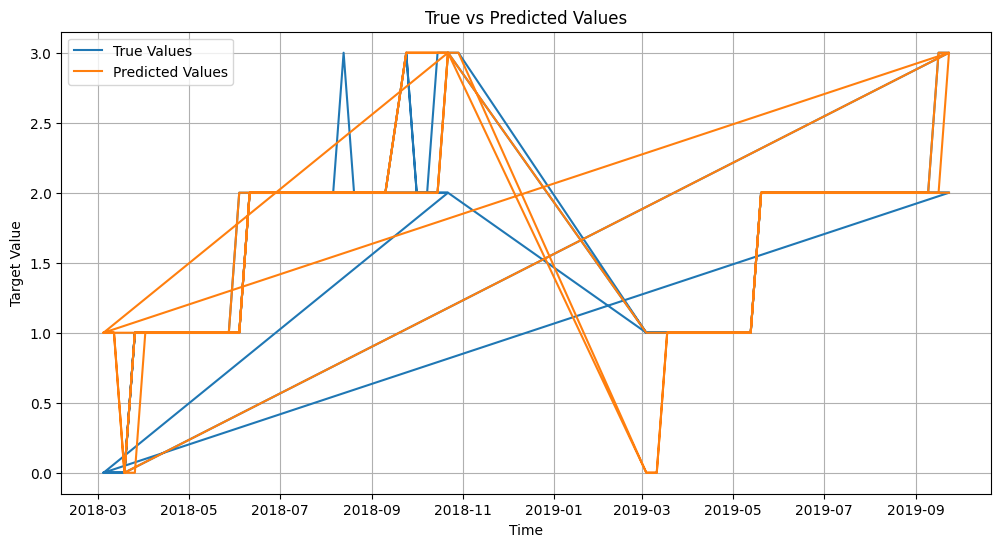

Shape of test set: X_test=(223, 28), y_test=(223,)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Confusion matrix total: 223


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from bayes_opt import BayesianOptimization
from statsmodels.tsa.seasonal import STL
from scipy.fftpack import fft
import warnings

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings('ignore')

# ==============================
# 1. Data Loading and Preprocessing
# ==============================
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath, delimiter=",", low_memory=False)
    df.columns = df.columns.str.replace('"', '').str.strip()

    if 'TIME' not in df.columns:
        raise KeyError("The column 'TIME' does not exist in the dataset.")

    df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
    df.dropna(subset=['TIME'], inplace=True)
    df.set_index('TIME', inplace=True)

    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)

    target_col = 'fenologia_h1'  # Change target column to 'fenologia_h1' for classification
    if target_col not in df.columns:
        raise KeyError(f"The target column '{target_col}' does not exist.")

    df[target_col].interpolate(method='linear', inplace=True)

    # Subtract 1 from the target column to make it 0-indexed (0, 1, 2, 3)
    df[target_col] = df[target_col] - 1

    # Lag features
    for i in range(1, 4):
        df[f'{target_col}_lag{i}'] = df[target_col].shift(i)

    # Rolling statistics
    for window in [3, 6]:
        df[f'{target_col}_roll_mean_{window}'] = df[target_col].rolling(window).mean()
        df[f'{target_col}_roll_std_{window}'] = df[target_col].rolling(window).std()

    # Time-based features for weekly data
    df['month'] = df.index.month                        # Useful for seasonal crop cycles
    df['weekofyear'] = df.index.isocalendar().week      # Week number in the year (1–52)
    df['year'] = df.index.isocalendar().year            # Optional: if data spans multiple years

    # Smooth cyclical encoding for week-of-year (annual periodicity)
    df['sin_week'] = np.sin(2 * np.pi * df['weekofyear'] / 52)
    df['cos_week'] = np.cos(2 * np.pi * df['weekofyear'] / 52)

    # Additional Feature 1: Exponential Moving Average (EMA)
    df['EMA_3'] = df[target_col].ewm(span=3, adjust=False).mean()  # EMA with span 3
    df['EMA_6'] = df[target_col].ewm(span=6, adjust=False).mean()  # EMA with span 6

    # Additional Feature 2: Rolling Correlation
    # We compute the correlation between the target and 'month' as an example
    df['correlation_target_month'] = df[target_col].rolling(window=6).corr(df['month'])
    df['correlation_target_week'] = df[target_col].rolling(window=6).corr(df['weekofyear'])

    # Additional Feature 3: Fourier Transform (FFT) Features
    # Apply FFT to the target variable and extract real and imaginary components
    fft_values = fft(df[target_col].dropna().values)
    fft_real = np.real(fft_values)[:len(df[target_col])]
    fft_imag = np.imag(fft_values)[:len(df[target_col])]
    
    df['fft_real'] = np.concatenate([fft_real, np.nan * np.ones(len(df) - len(fft_real))], axis=0)
    df['fft_imag'] = np.concatenate([fft_imag, np.nan * np.ones(len(df) - len(fft_imag))], axis=0)

    # Fill missing values
    df.fillna(df.median(), inplace=True)

    return df, target_col

# ==============================
# 2. Feature Scaling
# ==============================
def feature_scaling(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler

# ==============================
# 3. MLP Model Definition (For Classification)
# ==============================
def build_mlp_model(input_dim, num_classes=4, num_units=64, dropout_rate=0.2, activation='relu'):
    model = Sequential()
    model.add(Dense(num_units, activation=activation, input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units // 2, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ==============================
# 4. Objective Function for Bayesian Optimization
# ==============================
def objective_function(num_units, dropout_rate, activation, epochs, batch_size, X_train, y_train):
    activation_fn = ['relu', 'tanh', 'sigmoid'][int(activation)] 

    model = build_mlp_model(
        input_dim=X_train.shape[1],
        num_classes=4,  # Number of classes in the classification task
        num_units=int(num_units),
        dropout_rate=dropout_rate,
        activation=activation_fn
    )

    history = model.fit(
        X_train, y_train,
        epochs=int(epochs),
        batch_size=int(batch_size),
        validation_split=0.2,
        verbose=0
    )

    # Get the best validation accuracy (higher is better)
    val_accuracy = np.max(history.history['val_accuracy'])

    print(f"Trying: units={num_units}, dropout={dropout_rate}, activation={activation_fn}, epochs={epochs}, batch_size={batch_size} => val_accuracy={val_accuracy:.4f}")

    return val_accuracy  # Maximize validation accuracy

# ==============================
# 5. Bayesian Optimization Function
# ==============================
def optimize_hyperparameters(X_train, y_train):
    pbounds = {
        'num_units': (32, 128),
        'dropout_rate': (0.1, 0.5),
        'activation': (0, 2),
        'epochs': (50, 100),
        'batch_size': (16, 64)
    }

    optimizer = BayesianOptimization(
        f=lambda num_units, dropout_rate, activation, epochs, batch_size: objective_function(
            num_units, dropout_rate, activation, epochs, batch_size, X_train, y_train
        ),
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=15)
    return optimizer.max['params']

# ==============================
# 6. Final Model Training and Evaluation
# ==============================
def train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params):
    activation_list = ['relu', 'tanh', 'sigmoid']
    activation_fn = activation_list[int(best_params['activation'])]

    model = build_mlp_model(
        input_dim=X_train.shape[1],
        num_classes=4,  # Number of classes in the classification task
        num_units=int(best_params['num_units']),
        dropout_rate=float(best_params['dropout_rate']),
        activation=activation_fn
    )

    history = model.fit(
        X_train, y_train,
        epochs=int(best_params['epochs']),
        batch_size=int(best_params['batch_size']),
        validation_split=0.2,
        verbose=1
    )

    y_pred = model.predict(X_test).argmax(axis=1)  # Get the class with highest probability

    # Ensure correct alignment of y_pred and y_test (same number of instances)
    if len(y_pred) != len(y_test):
        raise ValueError("Mismatch between the number of predictions and actual test samples.")

    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    print("\n======================= Test Results =======================")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f"Total instances: {cm.sum()}")  # Ensure we're counting the correct total instances

    # Plotting results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='True Values')
    plt.plot(y_test.index, y_pred, label='Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Target Value')
    plt.title('True vs Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, history

# ==============================
# 7. Main Function
# ==============================
def main():
    # Load and preprocess training data
    train_filepath = r"E:\Abroad period research\Phenology datasets\PHENOLOGY_H1\Sevilla_train.csv"
    df_train, target_col = load_and_preprocess_data(train_filepath)

    # Apply feature scaling to training data
    X_train, y_train, scaler = feature_scaling(df_train, target_col)

    # Hyperparameter optimization
    print("\nStarting Hyperparameter Optimization...")
    best_params = optimize_hyperparameters(X_train, y_train)
    print("\nBest hyperparameters found:", best_params)

    # Load and preprocess test data (no feature engineering, just scaling)
    test_filepath = r"E:\Abroad period research\Phenology datasets\PHENOLOGY_H1\Sevilla_test.csv"
    df_test, _ = load_and_preprocess_data(test_filepath)

    # Apply feature scaling to test data
    X_test, y_test, _ = feature_scaling(df_test, target_col)

    # Train final model with optimized hyperparameters
    print("\nTraining Final Model with Optimized Hyperparameters...")
    model, history = train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params)

    print(f"Shape of test set: X_test={X_test.shape}, y_test={y_test.shape}")
    print(f"Confusion matrix total: {confusion_matrix(y_test, model.predict(X_test).argmax(axis=1)).sum()}")

if __name__ == "__main__":
    main()


BM + Lag + RWS + TBF + EMA  + Rolling Correlation (RC) 


Starting Hyperparameter Optimization...
|   iter    |  target   | activa... | batch_... | dropou... |  epochs   | num_units |
-------------------------------------------------------------------------------------
Trying: units=46.97778948247391, dropout=0.39279757672456206, activation=relu, epochs=79.93292420985183, batch_size=61.634286707675976 => val_accuracy=0.9857
| 1         | 0.9857    | 0.7491    | 61.63     | 0.3928    | 79.93     | 46.98     |
Trying: units=99.97496746842037, dropout=0.4464704583099741, activation=relu, epochs=80.05575058716045, batch_size=18.788013384073572 => val_accuracy=1.0000
| 2         | 1.0       | 0.312     | 18.79     | 0.4465    | 80.06     | 99.97     |
Trying: units=49.45519685188166, dropout=0.4329770563201687, activation=relu, epochs=60.61695553391381, batch_size=62.55567290377573 => val_accuracy=0.9714
| 3         | 0.9714    | 0.04117   | 62.56     | 0.433     | 60.62     | 49.46     |
Trying: units=59.95799745901202, dropout=0.309902572652895

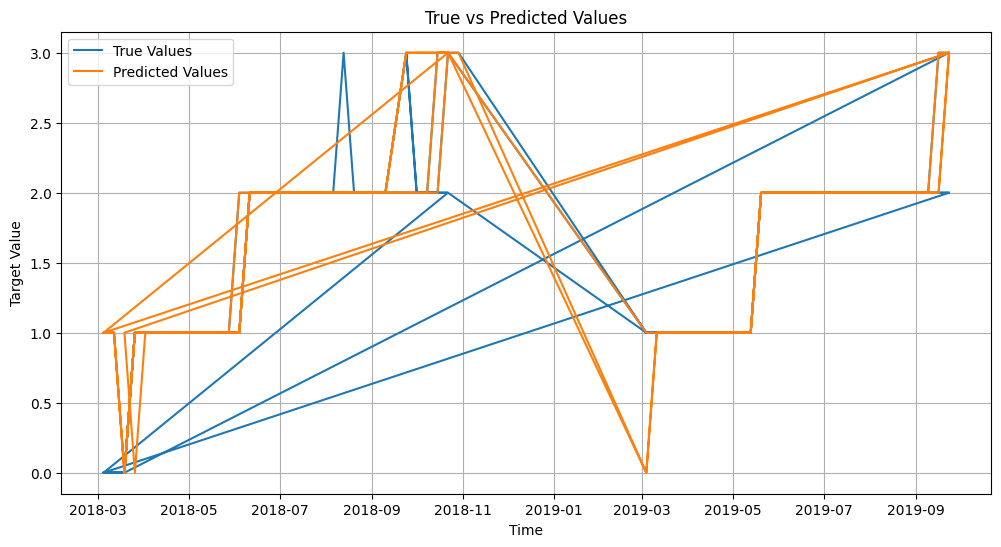

Shape of test set: X_test=(223, 26), y_test=(223,)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Confusion matrix total: 223


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from bayes_opt import BayesianOptimization
from statsmodels.tsa.seasonal import STL
from scipy.fftpack import fft
import warnings

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings('ignore')

# ==============================
# 1. Data Loading and Preprocessing
# ==============================
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath, delimiter=",", low_memory=False)
    df.columns = df.columns.str.replace('"', '').str.strip()

    if 'TIME' not in df.columns:
        raise KeyError("The column 'TIME' does not exist in the dataset.")

    df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
    df.dropna(subset=['TIME'], inplace=True)
    df.set_index('TIME', inplace=True)

    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)

    target_col = 'fenologia_h1'  # Change target column to 'fenologia_h1' for classification
    if target_col not in df.columns:
        raise KeyError(f"The target column '{target_col}' does not exist.")

    df[target_col].interpolate(method='linear', inplace=True)

    # Subtract 1 from the target column to make it 0-indexed (0, 1, 2, 3)
    df[target_col] = df[target_col] - 1

    # Lag features
    for i in range(1, 4):
        df[f'{target_col}_lag{i}'] = df[target_col].shift(i)

    # Rolling statistics
    for window in [3, 6]:
        df[f'{target_col}_roll_mean_{window}'] = df[target_col].rolling(window).mean()
        df[f'{target_col}_roll_std_{window}'] = df[target_col].rolling(window).std()

    # Time-based features for weekly data
    df['month'] = df.index.month                        # Useful for seasonal crop cycles
    df['weekofyear'] = df.index.isocalendar().week      # Week number in the year (1–52)
    df['year'] = df.index.isocalendar().year            # Optional: if data spans multiple years

    # Smooth cyclical encoding for week-of-year (annual periodicity)
    df['sin_week'] = np.sin(2 * np.pi * df['weekofyear'] / 52)
    df['cos_week'] = np.cos(2 * np.pi * df['weekofyear'] / 52)

    # Additional Feature 1: Exponential Moving Average (EMA)
    df['EMA_3'] = df[target_col].ewm(span=3, adjust=False).mean()  # EMA with span 3
    df['EMA_6'] = df[target_col].ewm(span=6, adjust=False).mean()  # EMA with span 6

    # Additional Feature 2: Rolling Correlation
    # We compute the correlation between the target and 'month' as an example
    df['correlation_target_month'] = df[target_col].rolling(window=6).corr(df['month'])
    df['correlation_target_week'] = df[target_col].rolling(window=6).corr(df['weekofyear'])

    # Additional Feature 3: Fourier Transform (FFT) Features
    # Apply FFT to the target variable and extract real and imaginary components
    # fft_values = fft(df[target_col].dropna().values)
    # fft_real = np.real(fft_values)[:len(df[target_col])]
    # fft_imag = np.imag(fft_values)[:len(df[target_col])]
    
    # df['fft_real'] = np.concatenate([fft_real, np.nan * np.ones(len(df) - len(fft_real))], axis=0)
    # df['fft_imag'] = np.concatenate([fft_imag, np.nan * np.ones(len(df) - len(fft_imag))], axis=0)

    # Fill missing values
    df.fillna(df.median(), inplace=True)

    return df, target_col

# ==============================
# 2. Feature Scaling
# ==============================
def feature_scaling(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler

# ==============================
# 3. MLP Model Definition (For Classification)
# ==============================
def build_mlp_model(input_dim, num_classes=4, num_units=64, dropout_rate=0.2, activation='relu'):
    model = Sequential()
    model.add(Dense(num_units, activation=activation, input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units // 2, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ==============================
# 4. Objective Function for Bayesian Optimization
# ==============================
def objective_function(num_units, dropout_rate, activation, epochs, batch_size, X_train, y_train):
    activation_fn = ['relu', 'tanh', 'sigmoid'][int(activation)] 

    model = build_mlp_model(
        input_dim=X_train.shape[1],
        num_classes=4,  # Number of classes in the classification task
        num_units=int(num_units),
        dropout_rate=dropout_rate,
        activation=activation_fn
    )

    history = model.fit(
        X_train, y_train,
        epochs=int(epochs),
        batch_size=int(batch_size),
        validation_split=0.2,
        verbose=0
    )

    # Get the best validation accuracy (higher is better)
    val_accuracy = np.max(history.history['val_accuracy'])

    print(f"Trying: units={num_units}, dropout={dropout_rate}, activation={activation_fn}, epochs={epochs}, batch_size={batch_size} => val_accuracy={val_accuracy:.4f}")

    return val_accuracy  # Maximize validation accuracy

# ==============================
# 5. Bayesian Optimization Function
# ==============================
def optimize_hyperparameters(X_train, y_train):
    pbounds = {
        'num_units': (32, 128),
        'dropout_rate': (0.1, 0.5),
        'activation': (0, 2),
        'epochs': (50, 100),
        'batch_size': (16, 64)
    }

    optimizer = BayesianOptimization(
        f=lambda num_units, dropout_rate, activation, epochs, batch_size: objective_function(
            num_units, dropout_rate, activation, epochs, batch_size, X_train, y_train
        ),
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=15)
    return optimizer.max['params']

# ==============================
# 6. Final Model Training and Evaluation
# ==============================
def train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params):
    activation_list = ['relu', 'tanh', 'sigmoid']
    activation_fn = activation_list[int(best_params['activation'])]

    model = build_mlp_model(
        input_dim=X_train.shape[1],
        num_classes=4,  # Number of classes in the classification task
        num_units=int(best_params['num_units']),
        dropout_rate=float(best_params['dropout_rate']),
        activation=activation_fn
    )

    history = model.fit(
        X_train, y_train,
        epochs=int(best_params['epochs']),
        batch_size=int(best_params['batch_size']),
        validation_split=0.2,
        verbose=1
    )

    y_pred = model.predict(X_test).argmax(axis=1)  # Get the class with highest probability

    # Ensure correct alignment of y_pred and y_test (same number of instances)
    if len(y_pred) != len(y_test):
        raise ValueError("Mismatch between the number of predictions and actual test samples.")

    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    print("\n======================= Test Results =======================")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f"Total instances: {cm.sum()}")  # Ensure we're counting the correct total instances

    # Plotting results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='True Values')
    plt.plot(y_test.index, y_pred, label='Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Target Value')
    plt.title('True vs Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, history

# ==============================
# 7. Main Function
# ==============================
def main():
    # Load and preprocess training data
    train_filepath = r"E:\Abroad period research\Phenology datasets\PHENOLOGY_H1\Sevilla_train.csv"
    df_train, target_col = load_and_preprocess_data(train_filepath)

    # Apply feature scaling to training data
    X_train, y_train, scaler = feature_scaling(df_train, target_col)

    # Hyperparameter optimization
    print("\nStarting Hyperparameter Optimization...")
    best_params = optimize_hyperparameters(X_train, y_train)
    print("\nBest hyperparameters found:", best_params)

    # Load and preprocess test data (no feature engineering, just scaling)
    test_filepath = r"E:\Abroad period research\Phenology datasets\PHENOLOGY_H1\Sevilla_test.csv"
    df_test, _ = load_and_preprocess_data(test_filepath)

    # Apply feature scaling to test data
    X_test, y_test, _ = feature_scaling(df_test, target_col)

    # Train final model with optimized hyperparameters
    print("\nTraining Final Model with Optimized Hyperparameters...")
    model, history = train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params)

    print(f"Shape of test set: X_test={X_test.shape}, y_test={y_test.shape}")
    print(f"Confusion matrix total: {confusion_matrix(y_test, model.predict(X_test).argmax(axis=1)).sum()}")

if __name__ == "__main__":
    main()


BM + Lag + RWS + TBF + EMA  


Starting Hyperparameter Optimization...
|   iter    |  target   | activa... | batch_... | dropou... |  epochs   | num_units |
-------------------------------------------------------------------------------------
Trying: units=46.97778948247391, dropout=0.39279757672456206, activation=relu, epochs=79.93292420985183, batch_size=61.634286707675976 => val_accuracy=1.0000
| 1         | 1.0       | 0.7491    | 61.63     | 0.3928    | 79.93     | 46.98     |
Trying: units=99.97496746842037, dropout=0.4464704583099741, activation=relu, epochs=80.05575058716045, batch_size=18.788013384073572 => val_accuracy=1.0000
| 2         | 1.0       | 0.312     | 18.79     | 0.4465    | 80.06     | 99.97     |
Trying: units=49.45519685188166, dropout=0.4329770563201687, activation=relu, epochs=60.61695553391381, batch_size=62.55567290377573 => val_accuracy=0.9714
| 3         | 0.9714    | 0.04117   | 62.56     | 0.433     | 60.62     | 49.46     |
Trying: units=59.95799745901202, dropout=0.309902572652895

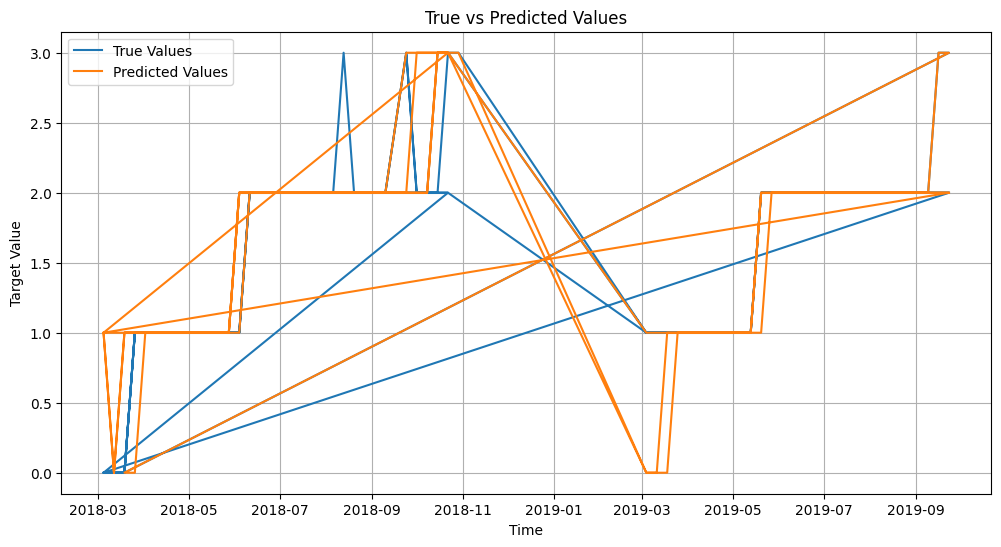

Shape of test set: X_test=(223, 24), y_test=(223,)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Confusion matrix total: 223


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from bayes_opt import BayesianOptimization
from statsmodels.tsa.seasonal import STL
from scipy.fftpack import fft
import warnings

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings('ignore')

# ==============================
# 1. Data Loading and Preprocessing
# ==============================
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath, delimiter=",", low_memory=False)
    df.columns = df.columns.str.replace('"', '').str.strip()

    if 'TIME' not in df.columns:
        raise KeyError("The column 'TIME' does not exist in the dataset.")

    df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
    df.dropna(subset=['TIME'], inplace=True)
    df.set_index('TIME', inplace=True)

    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)

    target_col = 'fenologia_h1'  # Change target column to 'fenologia_h1' for classification
    if target_col not in df.columns:
        raise KeyError(f"The target column '{target_col}' does not exist.")

    df[target_col].interpolate(method='linear', inplace=True)

    # Subtract 1 from the target column to make it 0-indexed (0, 1, 2, 3)
    df[target_col] = df[target_col] - 1

    # Lag features
    for i in range(1, 4):
        df[f'{target_col}_lag{i}'] = df[target_col].shift(i)

    # Rolling statistics
    for window in [3, 6]:
        df[f'{target_col}_roll_mean_{window}'] = df[target_col].rolling(window).mean()
        df[f'{target_col}_roll_std_{window}'] = df[target_col].rolling(window).std()

    # Time-based features for weekly data
    df['month'] = df.index.month                        # Useful for seasonal crop cycles
    df['weekofyear'] = df.index.isocalendar().week      # Week number in the year (1–52)
    df['year'] = df.index.isocalendar().year            # Optional: if data spans multiple years

    # Smooth cyclical encoding for week-of-year (annual periodicity)
    df['sin_week'] = np.sin(2 * np.pi * df['weekofyear'] / 52)
    df['cos_week'] = np.cos(2 * np.pi * df['weekofyear'] / 52)

    # Additional Feature 1: Exponential Moving Average (EMA)
    df['EMA_3'] = df[target_col].ewm(span=3, adjust=False).mean()  # EMA with span 3
    df['EMA_6'] = df[target_col].ewm(span=6, adjust=False).mean()  # EMA with span 6

    # Additional Feature 2: Rolling Correlation
    # We compute the correlation between the target and 'month' as an example
    # df['correlation_target_month'] = df[target_col].rolling(window=6).corr(df['month'])
    # df['correlation_target_week'] = df[target_col].rolling(window=6).corr(df['weekofyear'])

    # Additional Feature 3: Fourier Transform (FFT) Features
    # Apply FFT to the target variable and extract real and imaginary components
    # fft_values = fft(df[target_col].dropna().values)
    # fft_real = np.real(fft_values)[:len(df[target_col])]
    # fft_imag = np.imag(fft_values)[:len(df[target_col])]
    
    # df['fft_real'] = np.concatenate([fft_real, np.nan * np.ones(len(df) - len(fft_real))], axis=0)
    # df['fft_imag'] = np.concatenate([fft_imag, np.nan * np.ones(len(df) - len(fft_imag))], axis=0)

    # Fill missing values
    df.fillna(df.median(), inplace=True)

    return df, target_col

# ==============================
# 2. Feature Scaling
# ==============================
def feature_scaling(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler

# ==============================
# 3. MLP Model Definition (For Classification)
# ==============================
def build_mlp_model(input_dim, num_classes=4, num_units=64, dropout_rate=0.2, activation='relu'):
    model = Sequential()
    model.add(Dense(num_units, activation=activation, input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units // 2, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ==============================
# 4. Objective Function for Bayesian Optimization
# ==============================
def objective_function(num_units, dropout_rate, activation, epochs, batch_size, X_train, y_train):
    activation_fn = ['relu', 'tanh', 'sigmoid'][int(activation)] 

    model = build_mlp_model(
        input_dim=X_train.shape[1],
        num_classes=4,  # Number of classes in the classification task
        num_units=int(num_units),
        dropout_rate=dropout_rate,
        activation=activation_fn
    )

    history = model.fit(
        X_train, y_train,
        epochs=int(epochs),
        batch_size=int(batch_size),
        validation_split=0.2,
        verbose=0
    )

    # Get the best validation accuracy (higher is better)
    val_accuracy = np.max(history.history['val_accuracy'])

    print(f"Trying: units={num_units}, dropout={dropout_rate}, activation={activation_fn}, epochs={epochs}, batch_size={batch_size} => val_accuracy={val_accuracy:.4f}")

    return val_accuracy  # Maximize validation accuracy

# ==============================
# 5. Bayesian Optimization Function
# ==============================
def optimize_hyperparameters(X_train, y_train):
    pbounds = {
        'num_units': (32, 128),
        'dropout_rate': (0.1, 0.5),
        'activation': (0, 2),
        'epochs': (50, 100),
        'batch_size': (16, 64)
    }

    optimizer = BayesianOptimization(
        f=lambda num_units, dropout_rate, activation, epochs, batch_size: objective_function(
            num_units, dropout_rate, activation, epochs, batch_size, X_train, y_train
        ),
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=15)
    return optimizer.max['params']

# ==============================
# 6. Final Model Training and Evaluation
# ==============================
def train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params):
    activation_list = ['relu', 'tanh', 'sigmoid']
    activation_fn = activation_list[int(best_params['activation'])]

    model = build_mlp_model(
        input_dim=X_train.shape[1],
        num_classes=4,  # Number of classes in the classification task
        num_units=int(best_params['num_units']),
        dropout_rate=float(best_params['dropout_rate']),
        activation=activation_fn
    )

    history = model.fit(
        X_train, y_train,
        epochs=int(best_params['epochs']),
        batch_size=int(best_params['batch_size']),
        validation_split=0.2,
        verbose=1
    )

    y_pred = model.predict(X_test).argmax(axis=1)  # Get the class with highest probability

    # Ensure correct alignment of y_pred and y_test (same number of instances)
    if len(y_pred) != len(y_test):
        raise ValueError("Mismatch between the number of predictions and actual test samples.")

    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    print("\n======================= Test Results =======================")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f"Total instances: {cm.sum()}")  # Ensure we're counting the correct total instances

    # Plotting results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='True Values')
    plt.plot(y_test.index, y_pred, label='Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Target Value')
    plt.title('True vs Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, history

# ==============================
# 7. Main Function
# ==============================
def main():
    # Load and preprocess training data
    train_filepath = r"E:\Abroad period research\Phenology datasets\PHENOLOGY_H1\Sevilla_train.csv"
    df_train, target_col = load_and_preprocess_data(train_filepath)

    # Apply feature scaling to training data
    X_train, y_train, scaler = feature_scaling(df_train, target_col)

    # Hyperparameter optimization
    print("\nStarting Hyperparameter Optimization...")
    best_params = optimize_hyperparameters(X_train, y_train)
    print("\nBest hyperparameters found:", best_params)

    # Load and preprocess test data (no feature engineering, just scaling)
    test_filepath = r"E:\Abroad period research\Phenology datasets\PHENOLOGY_H1\Sevilla_test.csv"
    df_test, _ = load_and_preprocess_data(test_filepath)

    # Apply feature scaling to test data
    X_test, y_test, _ = feature_scaling(df_test, target_col)

    # Train final model with optimized hyperparameters
    print("\nTraining Final Model with Optimized Hyperparameters...")
    model, history = train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params)

    print(f"Shape of test set: X_test={X_test.shape}, y_test={y_test.shape}")
    print(f"Confusion matrix total: {confusion_matrix(y_test, model.predict(X_test).argmax(axis=1)).sum()}")

if __name__ == "__main__":
    main()


BM + Lag + RWS + TBF 


Starting Hyperparameter Optimization...
|   iter    |  target   | activa... | batch_... | dropou... |  epochs   | num_units |
-------------------------------------------------------------------------------------
Trying: units=46.97778948247391, dropout=0.39279757672456206, activation=relu, epochs=79.93292420985183, batch_size=61.634286707675976 => val_accuracy=0.9857
| 1         | 0.9857    | 0.7491    | 61.63     | 0.3928    | 79.93     | 46.98     |
Trying: units=99.97496746842037, dropout=0.4464704583099741, activation=relu, epochs=80.05575058716045, batch_size=18.788013384073572 => val_accuracy=1.0000
| 2         | 1.0       | 0.312     | 18.79     | 0.4465    | 80.06     | 99.97     |
Trying: units=49.45519685188166, dropout=0.4329770563201687, activation=relu, epochs=60.61695553391381, batch_size=62.55567290377573 => val_accuracy=0.9571
| 3         | 0.9571    | 0.04117   | 62.56     | 0.433     | 60.62     | 49.46     |
Trying: units=59.95799745901202, dropout=0.309902572652895

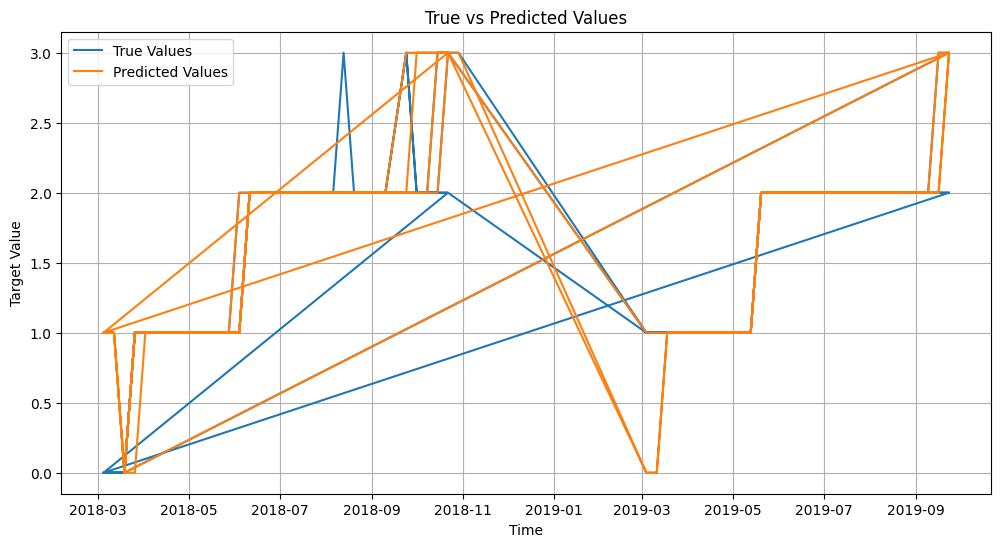

Shape of test set: X_test=(223, 22), y_test=(223,)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Confusion matrix total: 223


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from bayes_opt import BayesianOptimization
from statsmodels.tsa.seasonal import STL
from scipy.fftpack import fft
import warnings

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings('ignore')

# ==============================
# 1. Data Loading and Preprocessing
# ==============================
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath, delimiter=",", low_memory=False)
    df.columns = df.columns.str.replace('"', '').str.strip()

    if 'TIME' not in df.columns:
        raise KeyError("The column 'TIME' does not exist in the dataset.")

    df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
    df.dropna(subset=['TIME'], inplace=True)
    df.set_index('TIME', inplace=True)

    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)

    target_col = 'fenologia_h1'  # Change target column to 'fenologia_h1' for classification
    if target_col not in df.columns:
        raise KeyError(f"The target column '{target_col}' does not exist.")

    df[target_col].interpolate(method='linear', inplace=True)

    # Subtract 1 from the target column to make it 0-indexed (0, 1, 2, 3)
    df[target_col] = df[target_col] - 1

    # Lag features
    for i in range(1, 4):
        df[f'{target_col}_lag{i}'] = df[target_col].shift(i)

    # Rolling statistics
    for window in [3, 6]:
        df[f'{target_col}_roll_mean_{window}'] = df[target_col].rolling(window).mean()
        df[f'{target_col}_roll_std_{window}'] = df[target_col].rolling(window).std()

    # Time-based features for weekly data
    df['month'] = df.index.month                        # Useful for seasonal crop cycles
    df['weekofyear'] = df.index.isocalendar().week      # Week number in the year (1–52)
    df['year'] = df.index.isocalendar().year            # Optional: if data spans multiple years

    # Smooth cyclical encoding for week-of-year (annual periodicity)
    df['sin_week'] = np.sin(2 * np.pi * df['weekofyear'] / 52)
    df['cos_week'] = np.cos(2 * np.pi * df['weekofyear'] / 52)

    # Additional Feature 1: Exponential Moving Average (EMA)
    # df['EMA_3'] = df[target_col].ewm(span=3, adjust=False).mean()  # EMA with span 3
    # df['EMA_6'] = df[target_col].ewm(span=6, adjust=False).mean()  # EMA with span 6

    # Additional Feature 2: Rolling Correlation
    # We compute the correlation between the target and 'month' as an example
    # df['correlation_target_month'] = df[target_col].rolling(window=6).corr(df['month'])
    # df['correlation_target_week'] = df[target_col].rolling(window=6).corr(df['weekofyear'])

    # Additional Feature 3: Fourier Transform (FFT) Features
    # Apply FFT to the target variable and extract real and imaginary components
    # fft_values = fft(df[target_col].dropna().values)
    # fft_real = np.real(fft_values)[:len(df[target_col])]
    # fft_imag = np.imag(fft_values)[:len(df[target_col])]
    
    # df['fft_real'] = np.concatenate([fft_real, np.nan * np.ones(len(df) - len(fft_real))], axis=0)
    # df['fft_imag'] = np.concatenate([fft_imag, np.nan * np.ones(len(df) - len(fft_imag))], axis=0)

    # Fill missing values
    df.fillna(df.median(), inplace=True)

    return df, target_col

# ==============================
# 2. Feature Scaling
# ==============================
def feature_scaling(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler

# ==============================
# 3. MLP Model Definition (For Classification)
# ==============================
def build_mlp_model(input_dim, num_classes=4, num_units=64, dropout_rate=0.2, activation='relu'):
    model = Sequential()
    model.add(Dense(num_units, activation=activation, input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units // 2, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ==============================
# 4. Objective Function for Bayesian Optimization
# ==============================
def objective_function(num_units, dropout_rate, activation, epochs, batch_size, X_train, y_train):
    activation_fn = ['relu', 'tanh', 'sigmoid'][int(activation)] 

    model = build_mlp_model(
        input_dim=X_train.shape[1],
        num_classes=4,  # Number of classes in the classification task
        num_units=int(num_units),
        dropout_rate=dropout_rate,
        activation=activation_fn
    )

    history = model.fit(
        X_train, y_train,
        epochs=int(epochs),
        batch_size=int(batch_size),
        validation_split=0.2,
        verbose=0
    )

    # Get the best validation accuracy (higher is better)
    val_accuracy = np.max(history.history['val_accuracy'])

    print(f"Trying: units={num_units}, dropout={dropout_rate}, activation={activation_fn}, epochs={epochs}, batch_size={batch_size} => val_accuracy={val_accuracy:.4f}")

    return val_accuracy  # Maximize validation accuracy

# ==============================
# 5. Bayesian Optimization Function
# ==============================
def optimize_hyperparameters(X_train, y_train):
    pbounds = {
        'num_units': (32, 128),
        'dropout_rate': (0.1, 0.5),
        'activation': (0, 2),
        'epochs': (50, 100),
        'batch_size': (16, 64)
    }

    optimizer = BayesianOptimization(
        f=lambda num_units, dropout_rate, activation, epochs, batch_size: objective_function(
            num_units, dropout_rate, activation, epochs, batch_size, X_train, y_train
        ),
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=15)
    return optimizer.max['params']

# ==============================
# 6. Final Model Training and Evaluation
# ==============================
def train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params):
    activation_list = ['relu', 'tanh', 'sigmoid']
    activation_fn = activation_list[int(best_params['activation'])]

    model = build_mlp_model(
        input_dim=X_train.shape[1],
        num_classes=4,  # Number of classes in the classification task
        num_units=int(best_params['num_units']),
        dropout_rate=float(best_params['dropout_rate']),
        activation=activation_fn
    )

    history = model.fit(
        X_train, y_train,
        epochs=int(best_params['epochs']),
        batch_size=int(best_params['batch_size']),
        validation_split=0.2,
        verbose=1
    )

    y_pred = model.predict(X_test).argmax(axis=1)  # Get the class with highest probability

    # Ensure correct alignment of y_pred and y_test (same number of instances)
    if len(y_pred) != len(y_test):
        raise ValueError("Mismatch between the number of predictions and actual test samples.")

    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    print("\n======================= Test Results =======================")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f"Total instances: {cm.sum()}")  # Ensure we're counting the correct total instances

    # Plotting results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='True Values')
    plt.plot(y_test.index, y_pred, label='Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Target Value')
    plt.title('True vs Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, history

# ==============================
# 7. Main Function
# ==============================
def main():
    # Load and preprocess training data
    train_filepath = r"E:\Abroad period research\Phenology datasets\PHENOLOGY_H1\Sevilla_train.csv"
    df_train, target_col = load_and_preprocess_data(train_filepath)

    # Apply feature scaling to training data
    X_train, y_train, scaler = feature_scaling(df_train, target_col)

    # Hyperparameter optimization
    print("\nStarting Hyperparameter Optimization...")
    best_params = optimize_hyperparameters(X_train, y_train)
    print("\nBest hyperparameters found:", best_params)

    # Load and preprocess test data (no feature engineering, just scaling)
    test_filepath = r"E:\Abroad period research\Phenology datasets\PHENOLOGY_H1\Sevilla_test.csv"
    df_test, _ = load_and_preprocess_data(test_filepath)

    # Apply feature scaling to test data
    X_test, y_test, _ = feature_scaling(df_test, target_col)

    # Train final model with optimized hyperparameters
    print("\nTraining Final Model with Optimized Hyperparameters...")
    model, history = train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params)

    print(f"Shape of test set: X_test={X_test.shape}, y_test={y_test.shape}")
    print(f"Confusion matrix total: {confusion_matrix(y_test, model.predict(X_test).argmax(axis=1)).sum()}")

if __name__ == "__main__":
    main()


BM + Lag + RWS 


Starting Hyperparameter Optimization...
|   iter    |  target   | activa... | batch_... | dropou... |  epochs   | num_units |
-------------------------------------------------------------------------------------
Trying: units=46.97778948247391, dropout=0.39279757672456206, activation=relu, epochs=79.93292420985183, batch_size=61.634286707675976 => val_accuracy=0.9571
| 1         | 0.9571    | 0.7491    | 61.63     | 0.3928    | 79.93     | 46.98     |
Trying: units=99.97496746842037, dropout=0.4464704583099741, activation=relu, epochs=80.05575058716045, batch_size=18.788013384073572 => val_accuracy=1.0000
| 2         | 1.0       | 0.312     | 18.79     | 0.4465    | 80.06     | 99.97     |
Trying: units=49.45519685188166, dropout=0.4329770563201687, activation=relu, epochs=60.61695553391381, batch_size=62.55567290377573 => val_accuracy=0.9143
| 3         | 0.9143    | 0.04117   | 62.56     | 0.433     | 60.62     | 49.46     |
Trying: units=59.95799745901202, dropout=0.309902572652895

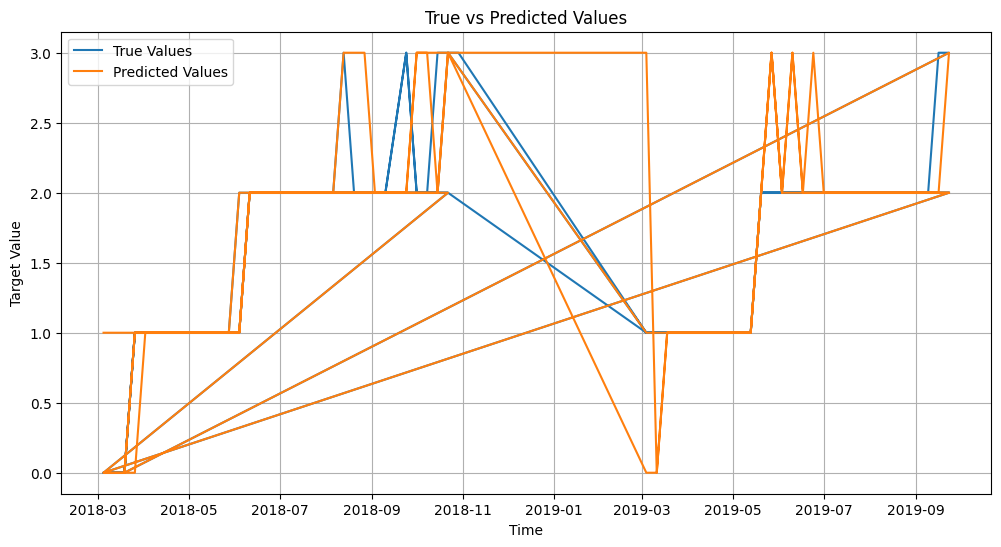

Shape of test set: X_test=(223, 17), y_test=(223,)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Confusion matrix total: 223


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from bayes_opt import BayesianOptimization
from statsmodels.tsa.seasonal import STL
from scipy.fftpack import fft
import warnings

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings('ignore')

# ==============================
# 1. Data Loading and Preprocessing
# ==============================
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath, delimiter=",", low_memory=False)
    df.columns = df.columns.str.replace('"', '').str.strip()

    if 'TIME' not in df.columns:
        raise KeyError("The column 'TIME' does not exist in the dataset.")

    df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
    df.dropna(subset=['TIME'], inplace=True)
    df.set_index('TIME', inplace=True)

    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)

    target_col = 'fenologia_h1'  # Change target column to 'fenologia_h1' for classification
    if target_col not in df.columns:
        raise KeyError(f"The target column '{target_col}' does not exist.")

    df[target_col].interpolate(method='linear', inplace=True)

    # Subtract 1 from the target column to make it 0-indexed (0, 1, 2, 3)
    df[target_col] = df[target_col] - 1

    # Lag features
    for i in range(1, 4):
        df[f'{target_col}_lag{i}'] = df[target_col].shift(i)

    # Rolling statistics
    for window in [3, 6]:
        df[f'{target_col}_roll_mean_{window}'] = df[target_col].rolling(window).mean()
        df[f'{target_col}_roll_std_{window}'] = df[target_col].rolling(window).std()

    # Time-based features for weekly data
    # df['month'] = df.index.month                        # Useful for seasonal crop cycles
    # df['weekofyear'] = df.index.isocalendar().week      # Week number in the year (1–52)
    # df['year'] = df.index.isocalendar().year            # Optional: if data spans multiple years

    # # Smooth cyclical encoding for week-of-year (annual periodicity)
    # df['sin_week'] = np.sin(2 * np.pi * df['weekofyear'] / 52)
    # df['cos_week'] = np.cos(2 * np.pi * df['weekofyear'] / 52)

    # Additional Feature 1: Exponential Moving Average (EMA)
    # df['EMA_3'] = df[target_col].ewm(span=3, adjust=False).mean()  # EMA with span 3
    # df['EMA_6'] = df[target_col].ewm(span=6, adjust=False).mean()  # EMA with span 6

    # Additional Feature 2: Rolling Correlation
    # We compute the correlation between the target and 'month' as an example
    # df['correlation_target_month'] = df[target_col].rolling(window=6).corr(df['month'])
    # df['correlation_target_week'] = df[target_col].rolling(window=6).corr(df['weekofyear'])

    # Additional Feature 3: Fourier Transform (FFT) Features
    # Apply FFT to the target variable and extract real and imaginary components
    # fft_values = fft(df[target_col].dropna().values)
    # fft_real = np.real(fft_values)[:len(df[target_col])]
    # fft_imag = np.imag(fft_values)[:len(df[target_col])]
    
    # df['fft_real'] = np.concatenate([fft_real, np.nan * np.ones(len(df) - len(fft_real))], axis=0)
    # df['fft_imag'] = np.concatenate([fft_imag, np.nan * np.ones(len(df) - len(fft_imag))], axis=0)

    # Fill missing values
    df.fillna(df.median(), inplace=True)

    return df, target_col

# ==============================
# 2. Feature Scaling
# ==============================
def feature_scaling(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler

# ==============================
# 3. MLP Model Definition (For Classification)
# ==============================
def build_mlp_model(input_dim, num_classes=4, num_units=64, dropout_rate=0.2, activation='relu'):
    model = Sequential()
    model.add(Dense(num_units, activation=activation, input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units // 2, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ==============================
# 4. Objective Function for Bayesian Optimization
# ==============================
def objective_function(num_units, dropout_rate, activation, epochs, batch_size, X_train, y_train):
    activation_fn = ['relu', 'tanh', 'sigmoid'][int(activation)] 

    model = build_mlp_model(
        input_dim=X_train.shape[1],
        num_classes=4,  # Number of classes in the classification task
        num_units=int(num_units),
        dropout_rate=dropout_rate,
        activation=activation_fn
    )

    history = model.fit(
        X_train, y_train,
        epochs=int(epochs),
        batch_size=int(batch_size),
        validation_split=0.2,
        verbose=0
    )

    # Get the best validation accuracy (higher is better)
    val_accuracy = np.max(history.history['val_accuracy'])

    print(f"Trying: units={num_units}, dropout={dropout_rate}, activation={activation_fn}, epochs={epochs}, batch_size={batch_size} => val_accuracy={val_accuracy:.4f}")

    return val_accuracy  # Maximize validation accuracy

# ==============================
# 5. Bayesian Optimization Function
# ==============================
def optimize_hyperparameters(X_train, y_train):
    pbounds = {
        'num_units': (32, 128),
        'dropout_rate': (0.1, 0.5),
        'activation': (0, 2),
        'epochs': (50, 100),
        'batch_size': (16, 64)
    }

    optimizer = BayesianOptimization(
        f=lambda num_units, dropout_rate, activation, epochs, batch_size: objective_function(
            num_units, dropout_rate, activation, epochs, batch_size, X_train, y_train
        ),
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=15)
    return optimizer.max['params']

# ==============================
# 6. Final Model Training and Evaluation
# ==============================
def train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params):
    activation_list = ['relu', 'tanh', 'sigmoid']
    activation_fn = activation_list[int(best_params['activation'])]

    model = build_mlp_model(
        input_dim=X_train.shape[1],
        num_classes=4,  # Number of classes in the classification task
        num_units=int(best_params['num_units']),
        dropout_rate=float(best_params['dropout_rate']),
        activation=activation_fn
    )

    history = model.fit(
        X_train, y_train,
        epochs=int(best_params['epochs']),
        batch_size=int(best_params['batch_size']),
        validation_split=0.2,
        verbose=1
    )

    y_pred = model.predict(X_test).argmax(axis=1)  # Get the class with highest probability

    # Ensure correct alignment of y_pred and y_test (same number of instances)
    if len(y_pred) != len(y_test):
        raise ValueError("Mismatch between the number of predictions and actual test samples.")

    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    print("\n======================= Test Results =======================")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f"Total instances: {cm.sum()}")  # Ensure we're counting the correct total instances

    # Plotting results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='True Values')
    plt.plot(y_test.index, y_pred, label='Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Target Value')
    plt.title('True vs Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, history

# ==============================
# 7. Main Function
# ==============================
def main():
    # Load and preprocess training data
    train_filepath = r"E:\Abroad period research\Phenology datasets\PHENOLOGY_H1\Sevilla_train.csv"
    df_train, target_col = load_and_preprocess_data(train_filepath)

    # Apply feature scaling to training data
    X_train, y_train, scaler = feature_scaling(df_train, target_col)

    # Hyperparameter optimization
    print("\nStarting Hyperparameter Optimization...")
    best_params = optimize_hyperparameters(X_train, y_train)
    print("\nBest hyperparameters found:", best_params)

    # Load and preprocess test data (no feature engineering, just scaling)
    test_filepath = r"E:\Abroad period research\Phenology datasets\PHENOLOGY_H1\Sevilla_test.csv"
    df_test, _ = load_and_preprocess_data(test_filepath)

    # Apply feature scaling to test data
    X_test, y_test, _ = feature_scaling(df_test, target_col)

    # Train final model with optimized hyperparameters
    print("\nTraining Final Model with Optimized Hyperparameters...")
    model, history = train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params)

    print(f"Shape of test set: X_test={X_test.shape}, y_test={y_test.shape}")
    print(f"Confusion matrix total: {confusion_matrix(y_test, model.predict(X_test).argmax(axis=1)).sum()}")

if __name__ == "__main__":
    main()


BM + Lag 


Starting Hyperparameter Optimization...
|   iter    |  target   | activa... | batch_... | dropou... |  epochs   | num_units |
-------------------------------------------------------------------------------------
Trying: units=46.97778948247391, dropout=0.39279757672456206, activation=relu, epochs=79.93292420985183, batch_size=61.634286707675976 => val_accuracy=0.9286
| 1         | 0.9286    | 0.7491    | 61.63     | 0.3928    | 79.93     | 46.98     |
Trying: units=99.97496746842037, dropout=0.4464704583099741, activation=relu, epochs=80.05575058716045, batch_size=18.788013384073572 => val_accuracy=0.9429
| 2         | 0.9429    | 0.312     | 18.79     | 0.4465    | 80.06     | 99.97     |
Trying: units=49.45519685188166, dropout=0.4329770563201687, activation=relu, epochs=60.61695553391381, batch_size=62.55567290377573 => val_accuracy=0.9000
| 3         | 0.9       | 0.04117   | 62.56     | 0.433     | 60.62     | 49.46     |
Trying: units=59.95799745901202, dropout=0.309902572652895

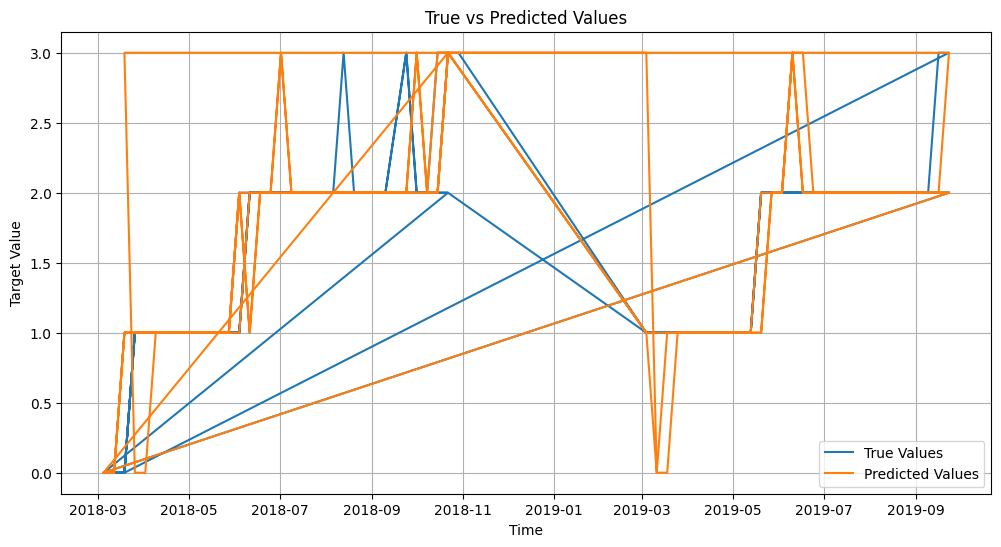

Shape of test set: X_test=(223, 13), y_test=(223,)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Confusion matrix total: 223


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from bayes_opt import BayesianOptimization
from statsmodels.tsa.seasonal import STL
from scipy.fftpack import fft
import warnings

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings('ignore')

# ==============================
# 1. Data Loading and Preprocessing
# ==============================
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath, delimiter=",", low_memory=False)
    df.columns = df.columns.str.replace('"', '').str.strip()

    if 'TIME' not in df.columns:
        raise KeyError("The column 'TIME' does not exist in the dataset.")

    df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
    df.dropna(subset=['TIME'], inplace=True)
    df.set_index('TIME', inplace=True)

    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)

    target_col = 'fenologia_h1'  # Change target column to 'fenologia_h1' for classification
    if target_col not in df.columns:
        raise KeyError(f"The target column '{target_col}' does not exist.")

    df[target_col].interpolate(method='linear', inplace=True)

    # Subtract 1 from the target column to make it 0-indexed (0, 1, 2, 3)
    df[target_col] = df[target_col] - 1

    # Lag features
    for i in range(1, 4):
        df[f'{target_col}_lag{i}'] = df[target_col].shift(i)

    # Rolling statistics
    # for window in [3, 6]:
    #     df[f'{target_col}_roll_mean_{window}'] = df[target_col].rolling(window).mean()
    #     df[f'{target_col}_roll_std_{window}'] = df[target_col].rolling(window).std()

    # Time-based features for weekly data
    # df['month'] = df.index.month                        # Useful for seasonal crop cycles
    # df['weekofyear'] = df.index.isocalendar().week      # Week number in the year (1–52)
    # df['year'] = df.index.isocalendar().year            # Optional: if data spans multiple years

    # # Smooth cyclical encoding for week-of-year (annual periodicity)
    # df['sin_week'] = np.sin(2 * np.pi * df['weekofyear'] / 52)
    # df['cos_week'] = np.cos(2 * np.pi * df['weekofyear'] / 52)

    # Additional Feature 1: Exponential Moving Average (EMA)
    # df['EMA_3'] = df[target_col].ewm(span=3, adjust=False).mean()  # EMA with span 3
    # df['EMA_6'] = df[target_col].ewm(span=6, adjust=False).mean()  # EMA with span 6

    # Additional Feature 2: Rolling Correlation
    # We compute the correlation between the target and 'month' as an example
    # df['correlation_target_month'] = df[target_col].rolling(window=6).corr(df['month'])
    # df['correlation_target_week'] = df[target_col].rolling(window=6).corr(df['weekofyear'])

    # Additional Feature 3: Fourier Transform (FFT) Features
    # Apply FFT to the target variable and extract real and imaginary components
    # fft_values = fft(df[target_col].dropna().values)
    # fft_real = np.real(fft_values)[:len(df[target_col])]
    # fft_imag = np.imag(fft_values)[:len(df[target_col])]
    
    # df['fft_real'] = np.concatenate([fft_real, np.nan * np.ones(len(df) - len(fft_real))], axis=0)
    # df['fft_imag'] = np.concatenate([fft_imag, np.nan * np.ones(len(df) - len(fft_imag))], axis=0)

    # Fill missing values
    df.fillna(df.median(), inplace=True)

    return df, target_col

# ==============================
# 2. Feature Scaling
# ==============================
def feature_scaling(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler

# ==============================
# 3. MLP Model Definition (For Classification)
# ==============================
def build_mlp_model(input_dim, num_classes=4, num_units=64, dropout_rate=0.2, activation='relu'):
    model = Sequential()
    model.add(Dense(num_units, activation=activation, input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units // 2, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ==============================
# 4. Objective Function for Bayesian Optimization
# ==============================
def objective_function(num_units, dropout_rate, activation, epochs, batch_size, X_train, y_train):
    activation_fn = ['relu', 'tanh', 'sigmoid'][int(activation)] 

    model = build_mlp_model(
        input_dim=X_train.shape[1],
        num_classes=4,  # Number of classes in the classification task
        num_units=int(num_units),
        dropout_rate=dropout_rate,
        activation=activation_fn
    )

    history = model.fit(
        X_train, y_train,
        epochs=int(epochs),
        batch_size=int(batch_size),
        validation_split=0.2,
        verbose=0
    )

    # Get the best validation accuracy (higher is better)
    val_accuracy = np.max(history.history['val_accuracy'])

    print(f"Trying: units={num_units}, dropout={dropout_rate}, activation={activation_fn}, epochs={epochs}, batch_size={batch_size} => val_accuracy={val_accuracy:.4f}")

    return val_accuracy  # Maximize validation accuracy

# ==============================
# 5. Bayesian Optimization Function
# ==============================
def optimize_hyperparameters(X_train, y_train):
    pbounds = {
        'num_units': (32, 128),
        'dropout_rate': (0.1, 0.5),
        'activation': (0, 2),
        'epochs': (50, 100),
        'batch_size': (16, 64)
    }

    optimizer = BayesianOptimization(
        f=lambda num_units, dropout_rate, activation, epochs, batch_size: objective_function(
            num_units, dropout_rate, activation, epochs, batch_size, X_train, y_train
        ),
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=15)
    return optimizer.max['params']

# ==============================
# 6. Final Model Training and Evaluation
# ==============================
def train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params):
    activation_list = ['relu', 'tanh', 'sigmoid']
    activation_fn = activation_list[int(best_params['activation'])]

    model = build_mlp_model(
        input_dim=X_train.shape[1],
        num_classes=4,  # Number of classes in the classification task
        num_units=int(best_params['num_units']),
        dropout_rate=float(best_params['dropout_rate']),
        activation=activation_fn
    )

    history = model.fit(
        X_train, y_train,
        epochs=int(best_params['epochs']),
        batch_size=int(best_params['batch_size']),
        validation_split=0.2,
        verbose=1
    )

    y_pred = model.predict(X_test).argmax(axis=1)  # Get the class with highest probability

    # Ensure correct alignment of y_pred and y_test (same number of instances)
    if len(y_pred) != len(y_test):
        raise ValueError("Mismatch between the number of predictions and actual test samples.")

    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    print("\n======================= Test Results =======================")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f"Total instances: {cm.sum()}")  # Ensure we're counting the correct total instances

    # Plotting results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='True Values')
    plt.plot(y_test.index, y_pred, label='Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Target Value')
    plt.title('True vs Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, history

# ==============================
# 7. Main Function
# ==============================
def main():
    # Load and preprocess training data
    train_filepath = r"E:\Abroad period research\Phenology datasets\PHENOLOGY_H1\Sevilla_train.csv"
    df_train, target_col = load_and_preprocess_data(train_filepath)

    # Apply feature scaling to training data
    X_train, y_train, scaler = feature_scaling(df_train, target_col)

    # Hyperparameter optimization
    print("\nStarting Hyperparameter Optimization...")
    best_params = optimize_hyperparameters(X_train, y_train)
    print("\nBest hyperparameters found:", best_params)

    # Load and preprocess test data (no feature engineering, just scaling)
    test_filepath = r"E:\Abroad period research\Phenology datasets\PHENOLOGY_H1\Sevilla_test.csv"
    df_test, _ = load_and_preprocess_data(test_filepath)

    # Apply feature scaling to test data
    X_test, y_test, _ = feature_scaling(df_test, target_col)

    # Train final model with optimized hyperparameters
    print("\nTraining Final Model with Optimized Hyperparameters...")
    model, history = train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params)

    print(f"Shape of test set: X_test={X_test.shape}, y_test={y_test.shape}")
    print(f"Confusion matrix total: {confusion_matrix(y_test, model.predict(X_test).argmax(axis=1)).sum()}")

if __name__ == "__main__":
    main()


BM 


Starting Hyperparameter Optimization...
|   iter    |  target   | activa... | batch_... | dropou... |  epochs   | num_units |
-------------------------------------------------------------------------------------
Trying: units=46.97778948247391, dropout=0.39279757672456206, activation=relu, epochs=79.93292420985183, batch_size=61.634286707675976 => val_accuracy=0.9143
| 1         | 0.9143    | 0.7491    | 61.63     | 0.3928    | 79.93     | 46.98     |
Trying: units=99.97496746842037, dropout=0.4464704583099741, activation=relu, epochs=80.05575058716045, batch_size=18.788013384073572 => val_accuracy=0.9429
| 2         | 0.9429    | 0.312     | 18.79     | 0.4465    | 80.06     | 99.97     |
Trying: units=49.45519685188166, dropout=0.4329770563201687, activation=relu, epochs=60.61695553391381, batch_size=62.55567290377573 => val_accuracy=0.9143
| 3         | 0.9143    | 0.04117   | 62.56     | 0.433     | 60.62     | 49.46     |
Trying: units=59.95799745901202, dropout=0.309902572652895

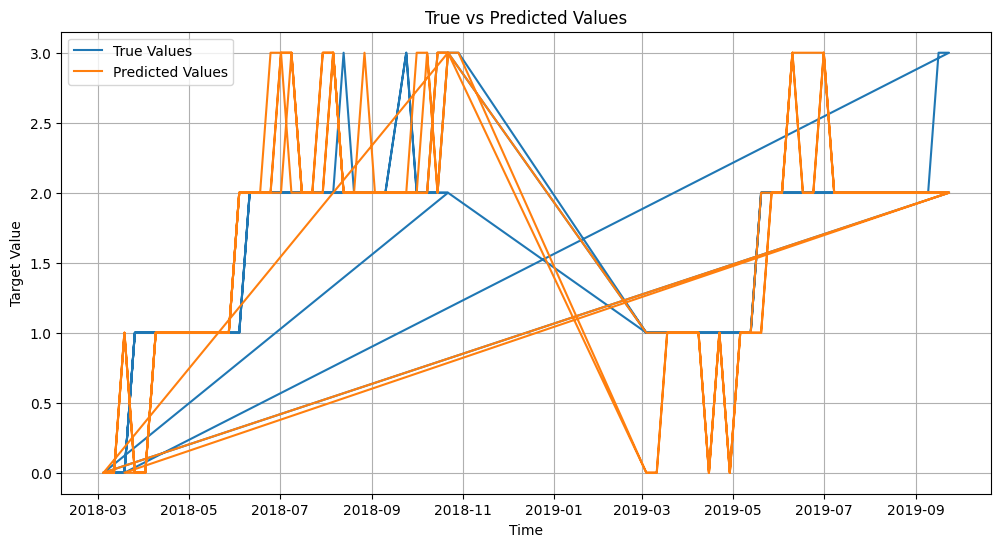

Shape of test set: X_test=(223, 10), y_test=(223,)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 141us/step
Confusion matrix total: 223


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from bayes_opt import BayesianOptimization
from statsmodels.tsa.seasonal import STL
from scipy.fftpack import fft
import warnings

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings('ignore')

# ==============================
# 1. Data Loading and Preprocessing
# ==============================
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath, delimiter=",", low_memory=False)
    df.columns = df.columns.str.replace('"', '').str.strip()

    if 'TIME' not in df.columns:
        raise KeyError("The column 'TIME' does not exist in the dataset.")

    df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
    df.dropna(subset=['TIME'], inplace=True)
    df.set_index('TIME', inplace=True)

    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)

    target_col = 'fenologia_h1'  # Change target column to 'fenologia_h1' for classification
    if target_col not in df.columns:
        raise KeyError(f"The target column '{target_col}' does not exist.")

    df[target_col].interpolate(method='linear', inplace=True)

    # Subtract 1 from the target column to make it 0-indexed (0, 1, 2, 3)
    df[target_col] = df[target_col] - 1

    # # Lag features
    # for i in range(1, 4):
    #     df[f'{target_col}_lag{i}'] = df[target_col].shift(i)

    # Rolling statistics
    # for window in [3, 6]:
    #     df[f'{target_col}_roll_mean_{window}'] = df[target_col].rolling(window).mean()
    #     df[f'{target_col}_roll_std_{window}'] = df[target_col].rolling(window).std()

    # Time-based features for weekly data
    # df['month'] = df.index.month                        # Useful for seasonal crop cycles
    # df['weekofyear'] = df.index.isocalendar().week      # Week number in the year (1–52)
    # df['year'] = df.index.isocalendar().year            # Optional: if data spans multiple years

    # # Smooth cyclical encoding for week-of-year (annual periodicity)
    # df['sin_week'] = np.sin(2 * np.pi * df['weekofyear'] / 52)
    # df['cos_week'] = np.cos(2 * np.pi * df['weekofyear'] / 52)

    # Additional Feature 1: Exponential Moving Average (EMA)
    # df['EMA_3'] = df[target_col].ewm(span=3, adjust=False).mean()  # EMA with span 3
    # df['EMA_6'] = df[target_col].ewm(span=6, adjust=False).mean()  # EMA with span 6

    # Additional Feature 2: Rolling Correlation
    # We compute the correlation between the target and 'month' as an example
    # df['correlation_target_month'] = df[target_col].rolling(window=6).corr(df['month'])
    # df['correlation_target_week'] = df[target_col].rolling(window=6).corr(df['weekofyear'])

    # Additional Feature 3: Fourier Transform (FFT) Features
    # Apply FFT to the target variable and extract real and imaginary components
    # fft_values = fft(df[target_col].dropna().values)
    # fft_real = np.real(fft_values)[:len(df[target_col])]
    # fft_imag = np.imag(fft_values)[:len(df[target_col])]
    
    # df['fft_real'] = np.concatenate([fft_real, np.nan * np.ones(len(df) - len(fft_real))], axis=0)
    # df['fft_imag'] = np.concatenate([fft_imag, np.nan * np.ones(len(df) - len(fft_imag))], axis=0)

    # Fill missing values
    df.fillna(df.median(), inplace=True)

    return df, target_col

# ==============================
# 2. Feature Scaling
# ==============================
def feature_scaling(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler

# ==============================
# 3. MLP Model Definition (For Classification)
# ==============================
def build_mlp_model(input_dim, num_classes=4, num_units=64, dropout_rate=0.2, activation='relu'):
    model = Sequential()
    model.add(Dense(num_units, activation=activation, input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_units // 2, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))  # Use softmax for multi-class classification

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ==============================
# 4. Objective Function for Bayesian Optimization
# ==============================
def objective_function(num_units, dropout_rate, activation, epochs, batch_size, X_train, y_train):
    activation_fn = ['relu', 'tanh', 'sigmoid'][int(activation)] 

    model = build_mlp_model(
        input_dim=X_train.shape[1],
        num_classes=4,  # Number of classes in the classification task
        num_units=int(num_units),
        dropout_rate=dropout_rate,
        activation=activation_fn
    )

    history = model.fit(
        X_train, y_train,
        epochs=int(epochs),
        batch_size=int(batch_size),
        validation_split=0.2,
        verbose=0
    )

    # Get the best validation accuracy (higher is better)
    val_accuracy = np.max(history.history['val_accuracy'])

    print(f"Trying: units={num_units}, dropout={dropout_rate}, activation={activation_fn}, epochs={epochs}, batch_size={batch_size} => val_accuracy={val_accuracy:.4f}")

    return val_accuracy  # Maximize validation accuracy

# ==============================
# 5. Bayesian Optimization Function
# ==============================
def optimize_hyperparameters(X_train, y_train):
    pbounds = {
        'num_units': (32, 128),
        'dropout_rate': (0.1, 0.5),
        'activation': (0, 2),
        'epochs': (50, 100),
        'batch_size': (16, 64)
    }

    optimizer = BayesianOptimization(
        f=lambda num_units, dropout_rate, activation, epochs, batch_size: objective_function(
            num_units, dropout_rate, activation, epochs, batch_size, X_train, y_train
        ),
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=5, n_iter=15)
    return optimizer.max['params']

# ==============================
# 6. Final Model Training and Evaluation
# ==============================
def train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params):
    activation_list = ['relu', 'tanh', 'sigmoid']
    activation_fn = activation_list[int(best_params['activation'])]

    model = build_mlp_model(
        input_dim=X_train.shape[1],
        num_classes=4,  # Number of classes in the classification task
        num_units=int(best_params['num_units']),
        dropout_rate=float(best_params['dropout_rate']),
        activation=activation_fn
    )

    history = model.fit(
        X_train, y_train,
        epochs=int(best_params['epochs']),
        batch_size=int(best_params['batch_size']),
        validation_split=0.2,
        verbose=1
    )

    y_pred = model.predict(X_test).argmax(axis=1)  # Get the class with highest probability

    # Ensure correct alignment of y_pred and y_test (same number of instances)
    if len(y_pred) != len(y_test):
        raise ValueError("Mismatch between the number of predictions and actual test samples.")

    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    print("\n======================= Test Results =======================")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f"Total instances: {cm.sum()}")  # Ensure we're counting the correct total instances

    # Plotting results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='True Values')
    plt.plot(y_test.index, y_pred, label='Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Target Value')
    plt.title('True vs Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, history

# ==============================
# 7. Main Function
# ==============================
def main():
    # Load and preprocess training data
    train_filepath = r"E:\Abroad period research\Phenology datasets\PHENOLOGY_H1\Sevilla_train.csv"
    df_train, target_col = load_and_preprocess_data(train_filepath)

    # Apply feature scaling to training data
    X_train, y_train, scaler = feature_scaling(df_train, target_col)

    # Hyperparameter optimization
    print("\nStarting Hyperparameter Optimization...")
    best_params = optimize_hyperparameters(X_train, y_train)
    print("\nBest hyperparameters found:", best_params)

    # Load and preprocess test data (no feature engineering, just scaling)
    test_filepath = r"E:\Abroad period research\Phenology datasets\PHENOLOGY_H1\Sevilla_test.csv"
    df_test, _ = load_and_preprocess_data(test_filepath)

    # Apply feature scaling to test data
    X_test, y_test, _ = feature_scaling(df_test, target_col)

    # Train final model with optimized hyperparameters
    print("\nTraining Final Model with Optimized Hyperparameters...")
    model, history = train_and_evaluate_model(X_train, X_test, y_train, y_test, best_params)

    print(f"Shape of test set: X_test={X_test.shape}, y_test={y_test.shape}")
    print(f"Confusion matrix total: {confusion_matrix(y_test, model.predict(X_test).argmax(axis=1)).sum()}")

if __name__ == "__main__":
    main()


BM + Lag + RWS + TBF + TLS

BM + Lag + RWS + TBF